In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
!pip install timm

In [ ]:
import os
if not os.path.exists('/content/H_7classes'):
    os.makedirs('/content/H_7classes')

In [ ]:
!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/region/H/aug_all_H.zip -d /content/H_7classes

In [ ]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!nvidia-smi

Wed May 29 06:07:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   66C    P8              18W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [ ]:
batch_size = 64
img_size = 224
model_type = 'regionH-all'

data_dir = '/content/H_7classes'

In [ ]:
mean_ = (0.5589, 0.5298, 0.5114)
std_ = (0.2119, 0.2031, 0.2015)

In [ ]:
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize
)

transforms = Compose(
        [
            ToTensor(),
            Normalize(mean_, std_)
        ]
    )

In [ ]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [ ]:
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
# valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms)

In [ ]:
torch.manual_seed(42)

train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
labels = dataset.classes
num_classes = len(labels)
labels

['A1_구진_플라크',
 'A2_비듬_각질_상피성잔고리',
 'A3_태선화_과다색소침착',
 'A4_농포_여드름',
 'A5_미란_궤양',
 'A6_결절_종괴',
 'A7_무증상']

In [ ]:
print(len(train_dataset), len(valid_dataset))

78960 19740


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

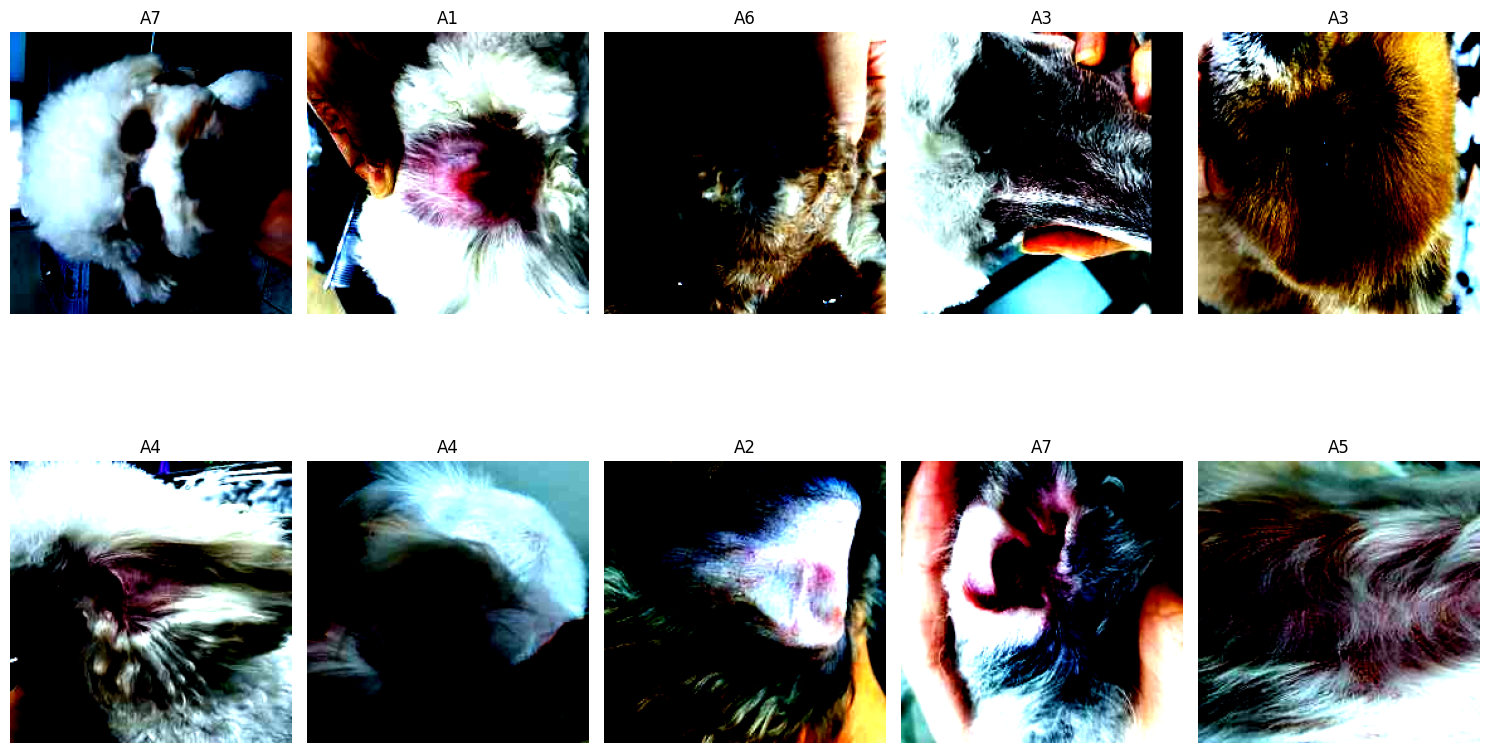

In [ ]:
valid_10 = [valid_dataset[i] for i in random.sample(list(range(0, 19740)), 10)]

fig, ax = plt.subplots(2, 5, figsize=(15, 10), tight_layout=True)

for i in range(2):
    for j in range(5):
        img = valid_10[(i*5)+j][0]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax[i][j].imshow(img)
        ax[i][j].set_title(labels[valid_10[(i*5)+j][1]][:2])
        ax[i][j].axis('off')

plt.show()

# Model Training

In [ ]:
# inception_v4 1536
# inception_resnet_v2 1536
# resnet50 2048
# resnetv2_50 2048
# efficientnet_b0 1280
# vit_base_patch16_224 768
# vit_base_patch8_224 768
# vit_base_resnet26d_224 768
# vit_base_resnet50d_224 768
# vit_small_resnet26d_224 768
# vit_small_resnet50d_s16_224 768

In [ ]:
model_name = 'inception_resnet_v2'
hidden_size = 768
pretrained = True
model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

In [ ]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name)

In [ ]:
# if pretrained:
#     for i, (name, param) in enumerate(model.named_parameters()):
#         if 'head' in name:
#           print(i, name)
#           break

#         param.requires_grad = False

In [ ]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [ ]:
class Classifier(nn.Module):
    def __init__(self, model, num_classes=2):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [ ]:
# classifier = Classifier(model, num_classes=num_classes).to(device)
classifier = model.to(device)

In [ ]:
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001) # correct_bias=False # Adam
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                         factor=0.5, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, lr_scheduler,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename):

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [ ]:
model_path = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [ ]:
def load_dict(model, optimizer, lr_scheduler, dict_file):

    pretrained = torch.load(dict_file)

    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    sch_dict = pretrained['lr_scheduler']
    labels = pretrained['label']

    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

    optimizer.load_state_dict(opt_dict)
    lr_scheduler.load_state_dict(sch_dict)

    return epoch, labels, model, optimizer, lr_scheduler

In [ ]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [ ]:
file_path = model_path

pretrained = False

In [ ]:
num_epochs = 10

best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
lr_epoch = []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}.pt')
    pkl_file = os.path.join(file_path, f'{model_name}.pickle')

    epoch_start, labels, model, optimizer, lr_scheduler = load_dict(classifier, optimizer, lr_scheduler, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']
    best_val_acc, best_val_loss = max(val_acc_epoch), min(val_loss_epoch)

In [ ]:
print(epoch_start, best_val_acc, best_val_loss)

0 0.0 100.0


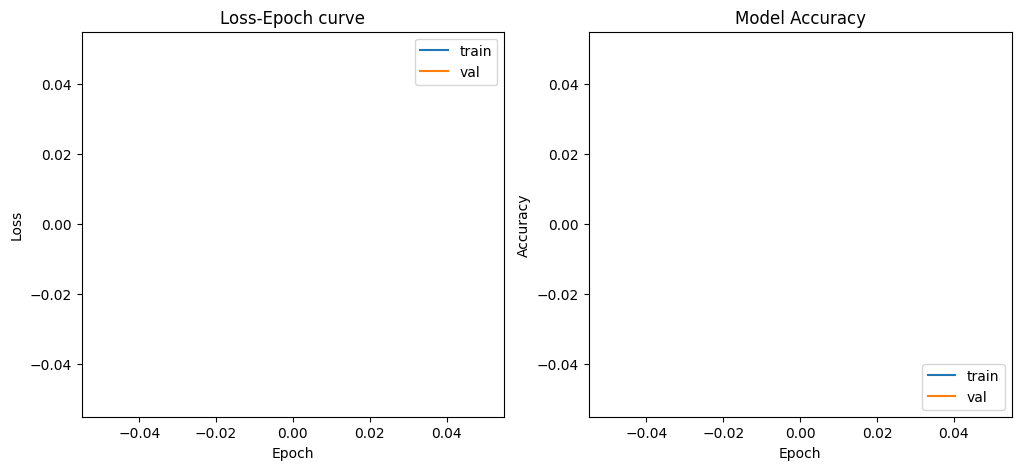

In [ ]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [ ]:
epoch_start = e

epoch 6 train acc 0.890325330902215 validation acc 0.7743007397133611


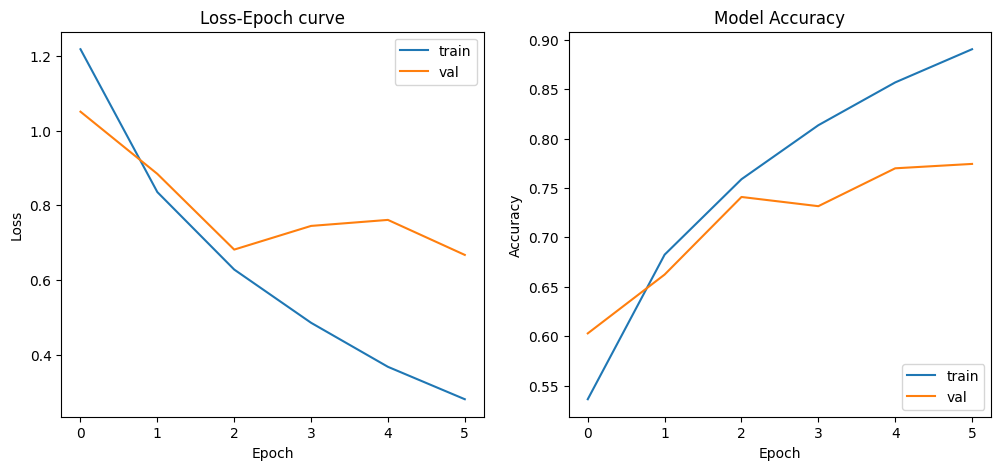

  0%|          | 0/1234 [00:00<?, ?it/s]

epoch 7 train acc 0.9112388573743923 loss 0.22778715930480625 lr 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

epoch 7 valid acc 0.7810260633379565 loss 0.6937170707677947


  0%|          | 0/1234 [00:00<?, ?it/s]

epoch 8 train acc 0.9249983117233929 loss 0.19266828033330471 lr 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

epoch 8 valid acc 0.7844212320850671 loss 0.6939172030073925


  0%|          | 0/1234 [00:00<?, ?it/s]

epoch 9 train acc 0.9305696245272826 loss 0.17202808570291853 lr 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

epoch 9 valid acc 0.7886110147942672 loss 0.7076317880628178


  0%|          | 0/1234 [00:00<?, ?it/s]

epoch 10 train acc 0.9609839276066992 loss 0.09034995350162567 lr 0.0005


  0%|          | 0/309 [00:00<?, ?it/s]

epoch 10 valid acc 0.8203955732778548 loss 0.7343439464623103


In [27]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    lr = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr)
    print("epoch {} train acc {} loss {} lr {}".format(e, tot_train_acc, mean_train_loss, lr))

    classifier.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

            img = batch[0].to(device)
            label = batch[1].to(device) # .squeeze(1)

            out = classifier(img).squeeze(1)
            loss = loss_fn(out, label)
            val_loss += loss.item()
            val_acc += calc_accuracy(out, label)

    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    lr_scheduler.step(mean_val_loss)

    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, model_name)

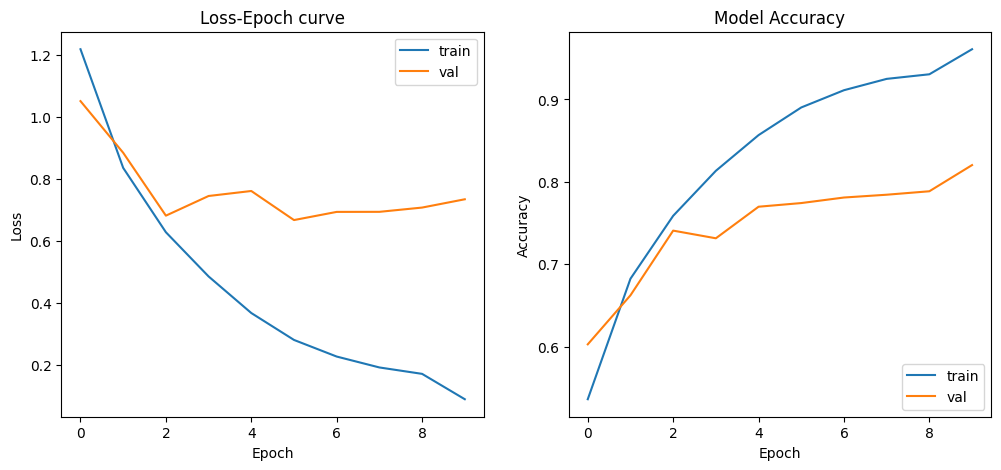

In [28]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

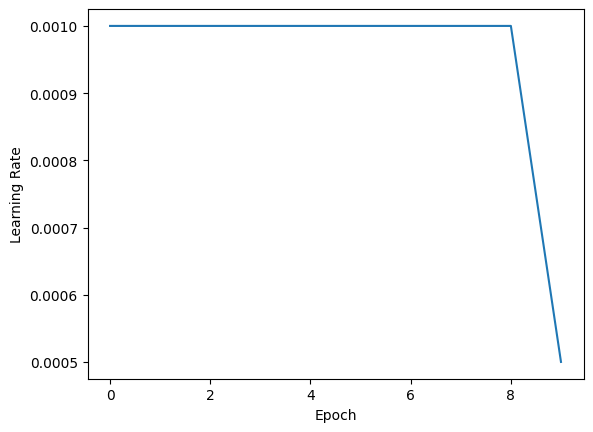

In [29]:
plt.plot(lr_epoch)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# Inference

In [30]:
def inference(img_path):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img)
    img = Normalize(mean_, std_)(img).unsqueeze(0)

    outputs = classifier(img.to(device))
    result = outputs.softmax(1) # logits.
    result_dict = {}

    for i, value in enumerate(result[0].tolist()):
        result_dict[labels[i]] = value

    result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

    return result

In [31]:
file_root = '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized'
test_files = []
for folder in os.listdir(file_root):
    files = random.sample(os.listdir(os.path.join(file_root, folder)), 1)
    test_files.extend([os.path.join(file_root, folder, file) for file in files])
print(test_files)

['/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A1_구진_플라크/IMG_D_A1_036416.jpg', '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A7_무증상/IMG_D_A7_375232.jpg', '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A2_비듬_각질_상피성잔고리/IMG_D_A2_464927.jpg', '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A3_태선화_과다색소침착/IMG_D_A3_173437.jpg', '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A4_농포_여드름/IMG_D_A4_447030.jpg', '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A5_미란_궤양/IMG_D_A5_491930.jpg', '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A6_결절_종괴/IMG_D_A6_498558.jpg']


In [32]:
for file in test_files:
    result = inference(file)
    print(file)
    print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')
    print()

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A1_구진_플라크/IMG_D_A1_036416.jpg
A3_태선화_과다색소침착일 확률이 62%, A1_구진_플라크일 확률이 28% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A7_무증상/IMG_D_A7_375232.jpg
A2_비듬_각질_상피성잔고리일 확률이 82%, A1_구진_플라크일 확률이 8% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A2_비듬_각질_상피성잔고리/IMG_D_A2_464927.jpg
A5_미란_궤양일 확률이 68%, A6_결절_종괴일 확률이 27% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A3_태선화_과다색소침착/IMG_D_A3_173437.jpg
A2_비듬_각질_상피성잔고리일 확률이 99%, A3_태선화_과다색소침착일 확률이 0% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A4_농포_여드름/IMG_D_A4_447030.jpg
A1_구진_플라크일 확률이 65%, A3_태선화_과다색소침착일 확률이 33% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A5_미란_궤양/IMG_D_A5_491930.jpg
A2_비듬_각질_상피성잔고리일 확률이 98%, A5_미란_궤양일 확률이 1% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A6_ᄀ

In [ ]:
# file_path = '/kaggle/input/cv-skin-disease/disease/IMG_C_A2_201354.jpg'
# result = inference(file_path)
# print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')

In [ ]:
# img = Image.open('/kaggle/input/skin-cat/test_cat_resized/A2_비듬_각질_상피성잔고리/IMG_C_A2_201688.jpg')
# encoding = feature_extractor(images=img, return_tensors='pt')

In [ ]:
# !pip install onnxruntime

In [ ]:
# import onnxruntime
# import time

# ort_session = onnxruntime.InferenceSession(filepath)
# input_name = ort_session.get_inputs()[0].name
# ort_inputs = {input_name: encoding['pixel_values'].numpy()}

# s = time.time()
# ort_outs = ort_session.run(None, ort_inputs)
# e = time.time()

# print(f'inference takes {e-s} sec')

In [ ]:
# from scipy.special import softmax

In [ ]:
# softmax(ort_outs)

In [ ]:
# encoding['pixel_values'].size()

In [ ]:
# ort_inputs

In [ ]:
# dataset.class_to_idx

In [ ]:
# import pickle

# with open('/kaggle/working/classes.pkl', 'wb') as f:
#     pickle.dump(id2label, f)